### Introduction

This tutorial outlines a quantitative workflow for characterizing desmoplastic stroma in whole-slide images (WSIs), a key indicator in many cancer types. Desmoplasia refers to the growth of fibrous connective tissue in response to a tumor, a process where the stroma becomes stiff and remodels the tumor microenvironment. A crucial aspect of this process is distinguishing between immature and mature desmoplastic stroma.

This guide will walk you through a series of steps to extract a set of features designed to characterize desmoplastic stroma. We will use a segmented HGSC omental slide as an example data in this workflow.

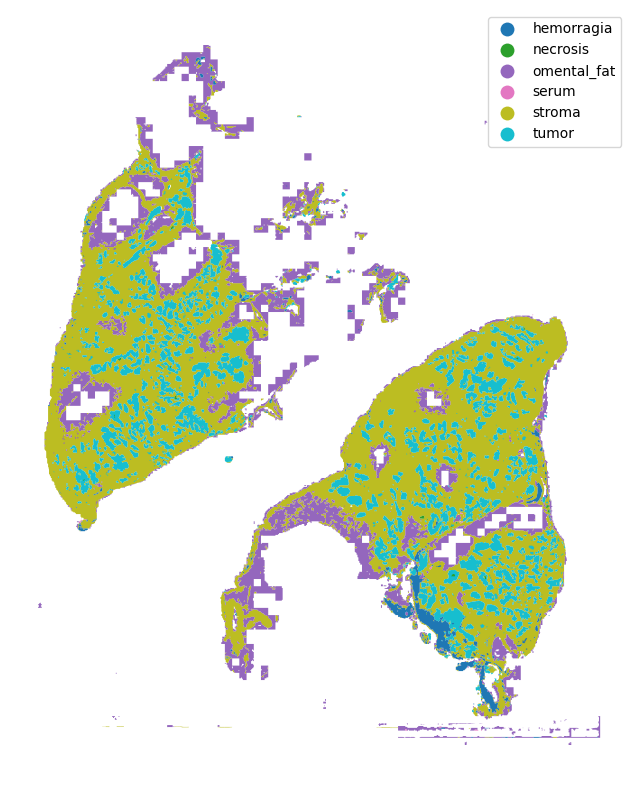

In [ ]:
import geopandas as gpd

nuc = gpd.read_parquet("/path/to/nuclei_seg.parquet")  # <- modify path
tis = gpd.read_parquet("/path/to/tissue_seg.parquet")  # <- modify path

ax = tis.plot(figsize=(10, 10), column="class_name", legend=True)
ax.set_axis_off()

### Fit a Rectangular Grid to the Tissue Segmentation Map

First, we'll create a rectangular grid over the tissue segmentation map from which we will filter only relevant parts to be analyzed. Firstly, the segmentation map contains two identical sections, we will only analyze one of them to reduce computational cost. Secondly, we are extracting stromal features so we will constrain our analysis to the stromal regions.

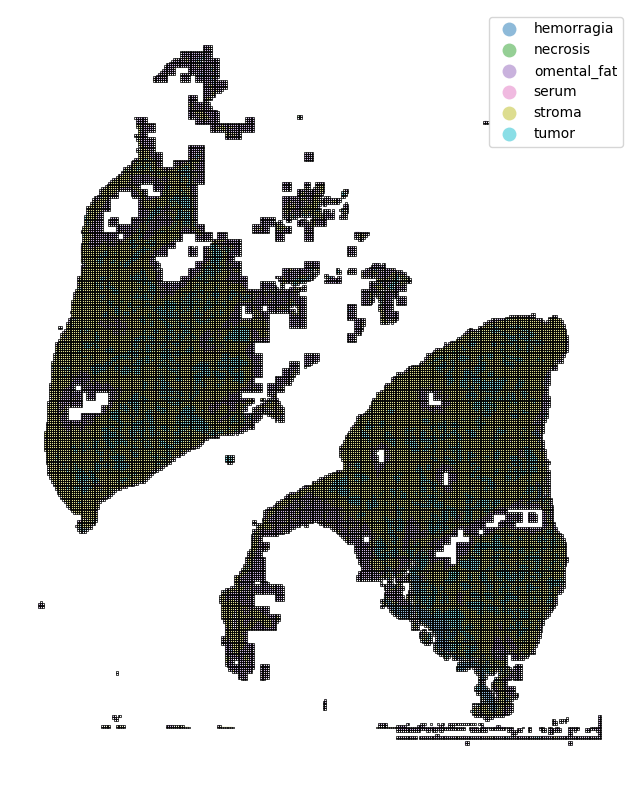

In [2]:
from histolytics.spatial_ops.rect_grid import rect_grid

# fit the grid. We'll use 256, 256 sized patches, focus only on stroma
patch_size = (256, 256)
gr = rect_grid(tis, patch_size, 0, "intersects")
ax = tis.plot(column="class_name", figsize=(10, 10), alpha=0.5, legend=True)
ax = gr.plot(ax=ax, edgecolor="black", facecolor="none", lw=0.5)
ax.set_axis_off()

Let's now filter out the other tissue section and constrain the bboxes to the stromal regions.

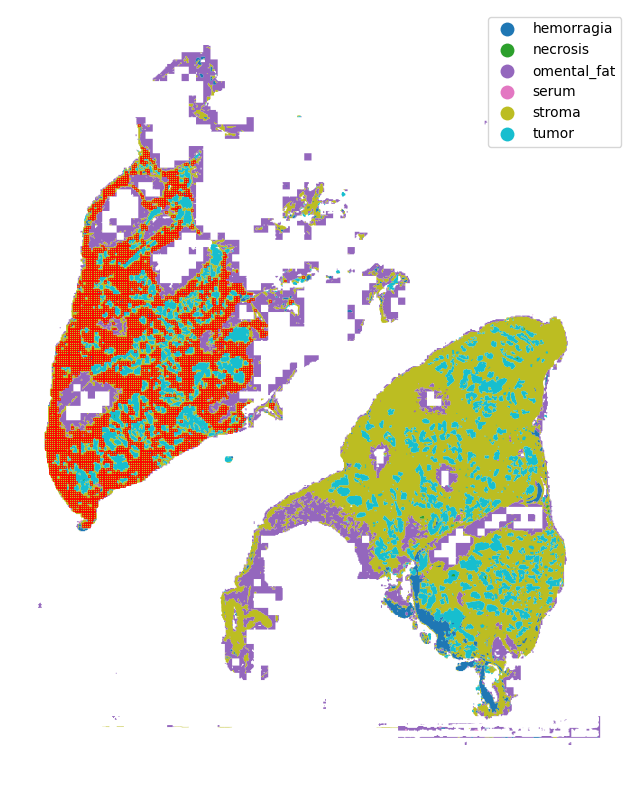

In [3]:
from histolytics.wsi.utils import get_sub_grids
from histolytics.spatial_ops.ops import get_objs

sub_grids = get_sub_grids(gr, min_size=1000, return_gdf=True)
gr = get_objs(tis.loc[tis["class_name"] == "stroma"], sub_grids[1], "contains")
gr = gr.reset_index(drop=True)

ax = tis.plot(column="class_name", aspect=1, figsize=(10, 10), legend=True)
ax = gr.boundary.plot(ax=ax, lw=0.5, color="red")
ax.set_axis_off()

In [4]:
# Visualize the grid on top of the slide
# thumbnail = reader.read_level(-2)
# reader.get_annotated_thumbnail(thumbnail, gr, linewidth=1)

### Initialize Desmoplastic Stroma Feature Extraction Pipeline

Now, we will define our pipeline. We will be extracting features based on prior knowledge of desmoplastic stroma characteristics:

Mature Desmoplasia should have:
 - more pronounced eosin staining (pinkish) in comparison to immature desmoplasia.
 - less deviation in collagen orientation.

Immature Desmoplasia should have:
 - more prominent hematoxylin staining in comparison to mature desmoplasia (blueish).
 - more deviation in collagen orientation.

To quantify these phenomena, we will extract a total of 10 features from the stromal regions:
1. The standard deviation of collagen fiber orientation.
2. The mean tortuosity of collagen fibers.
3. Mean RGB-intensities of the stromal regions, especially the eosin and hematoxylin stains.
4. The area of eosin and hematoxylin stain masks.

In [ ]:
import numpy as np
import pandas as pd
from histolytics.wsi.wsi_iterator import WSIPatchIterator
from histolytics.stroma_feats.collagen import fiber_feats
from histolytics.stroma_feats.intensity import stromal_intensity_feats
from histolytics.wsi.slide_reader import SlideReader


def pipeline(img: np.ndarray, label: np.ndarray, mask: np.ndarray) -> pd.DataFrame:
    """A pipeline for extracting features from WSI stromal patches."""
    collagen_feats: gpd.GeoDataFrame = fiber_feats(
        img,
        label=label,
        mask=mask,
        metrics=("major_axis_angle", "tortuosity"),
        rm_bg=True,
        rm_fg=False,
        return_edges=False,
    )

    if len(collagen_feats) < 3:
        fiber_orientation_std = 0
        tortuosity_mean = 0
    else:
        fiber_orientation_std = collagen_feats["major_axis_angle"].std()
        tortuosity_mean = collagen_feats["tortuosity"].mean()

    collagen_feats = pd.Series(
        {
            "fiber_orientation_std": fiber_orientation_std,
            "tortuosity_mean": tortuosity_mean,
        }
    )

    stromal_feats: pd.Series = stromal_intensity_feats(
        img, label=label, mask=mask, metrics=["mean"]
    )
    combined_feats = pd.concat([collagen_feats, stromal_feats], axis=0)
    return combined_feats


sl_p = "/path/to/slide.mrxs"  # <- modify path
reader = SlideReader(sl_p, backend="OPENSLIDE")

crop_loader = WSIPatchIterator(
    slide_reader=reader,
    grid=gr,
    nuclei=nuc,
    pipeline_func=pipeline,
    batch_size=8,
    num_workers=8,
    pin_memory=False,
    shuffle=False,
    drop_last=False,
)

Let's now iterate over the cropped patches and apply the feature extraction pipeline. This takes a few minutes on a regular laptop.

In [6]:
import pandas as pd
from tqdm import tqdm

crop_feats = []
with crop_loader as loader:
    with tqdm(loader, unit="batch", total=len(loader)) as pbar:
        for batch_idx, batch in enumerate(pbar):
            crop_feats.extend(batch)  # collect the patch level dfs


100%|██████████| 718/718 [05:07<00:00,  2.33batch/s]


In [7]:
crop_feats_df = pd.DataFrame([series for _, series in crop_feats])
crop_feats_df.index = [idx for idx, _ in crop_feats]
crop_feats_df.index.name = "uid"

# merge the grid gdf and the feature df
grid_feats = gr.merge(crop_feats_df, left_index=True, right_index=True)
grid_feats["geometry"] = grid_feats.geometry.boundary
grid_feats.head(3)

,geometry,fiber_orientation_std,tortuosity_mean,hematoxylin_area,hematoxylin_R_mean,hematoxylin_G_mean,hematoxylin_B_mean,eosin_area,eosin_R_mean,eosin_G_mean,eosin_B_mean
0,"LINESTRING (6726 67466, 6726 67722, 6470 67722...",20.107610,1.469182,1657.0,0.750142,0.734647,0.876184,2603.0,0.972066,0.681243,0.956540
1,"LINESTRING (7494 67466, 7494 67722, 7238 67722...",25.209740,1.704413,13925.0,0.775036,0.760802,0.889430,42164.0,0.969307,0.648682,0.952238
2,"LINESTRING (7750 67466, 7750 67722, 7494 67722...",25.403968,1.683213,23361.0,0.780649,0.766445,0.893465,31992.0,0.978101,0.733881,0.965822


Let's do a quick visualization to see how a feature looks like on the segmented slide.

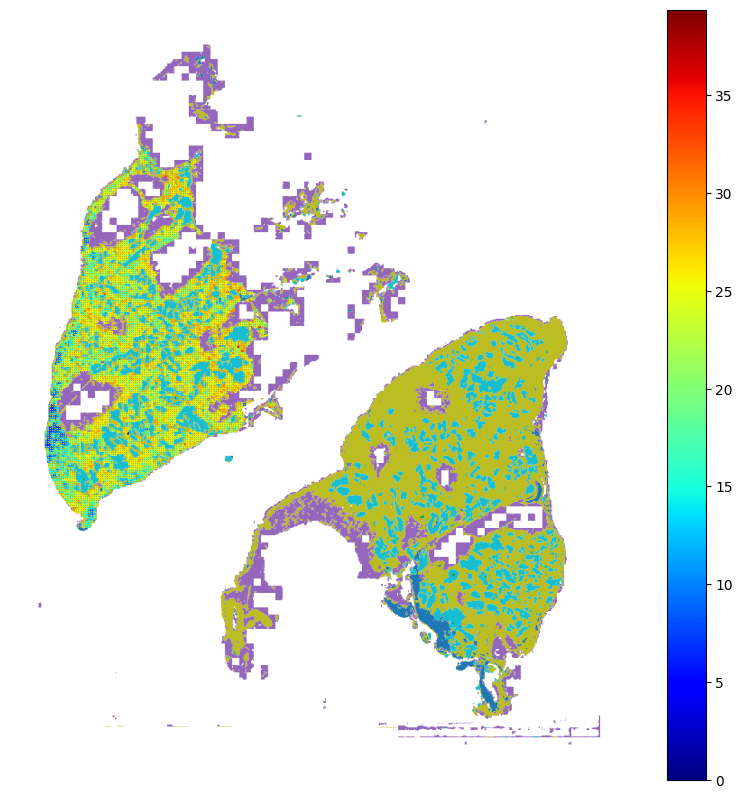

In [8]:
ax = tis.plot(column="class_name", aspect=1, figsize=(10, 10))
ax = grid_feats.plot(
    ax=ax, column="fiber_orientation_std", legend=True, lw=0.5, cmap="jet"
)
ax.set_axis_off()

### Clustering the Stromal Features

Next, we'll cluster the stromal features using KMeans clustering. We will first scale the features and then determine the optimal number of clusters using the silhouette score.

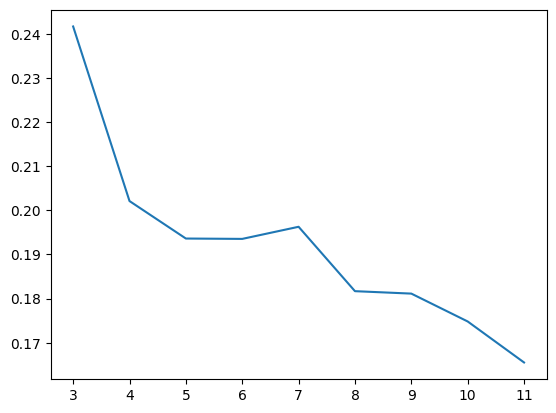

In [9]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import minmax_scale
from sklearn import set_config


set_config(transform_output="pandas")  # return pandas dataframes


def export_legend(legend, filename="legend.png", expand=[-5, -5, 5, 5]):
    fig = legend.figure
    fig.canvas.draw()
    bbox = legend.get_window_extent()
    bbox = bbox.from_extents(*(bbox.extents + np.array(expand)))
    bbox = bbox.transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, dpi="figure", bbox_inches=bbox)


# helper function to calculate Silhouette score for a range of clusters
def get_silhouette(range: range, clust_vars):
    sil_score = []
    for i in range:
        kmeans = KMeans(n_clusters=i, random_state=42)
        kmeans.fit(clust_vars)
        labels = kmeans.labels_

        # calculate Silhouette score
        score = silhouette_score(
            clust_vars, labels, metric="euclidean", sample_size=1000, random_state=200
        )
        sil_score.append(score)

    return sil_score


# drop the geometry column for clustering
cols = grid_feats.columns
clust_vars = grid_feats.loc[:, ~cols.isin(["geometry"])]

# scale the features
cols = clust_vars.columns
clust_vars = minmax_scale(clust_vars)
clust_vars.columns = cols
clust_vars = clust_vars.fillna(0)

sil_score = get_silhouette(
    range(3, 12),
    clust_vars,
)

# select the highest silhouette score
n_clust = range(3, 12)[np.argmax(sil_score)]
plt.plot(range(3, 12), sil_score, label=f"Optimal number of clusters: {n_clust}")

And then we'll cluster!

In [10]:
kmeans = KMeans(n_clusters=n_clust, random_state=42)
kmeans.fit(clust_vars)
grid_feats["labels"] = kmeans.labels_
grid_feats["labels"] = grid_feats["labels"] + 1
grid_feats["labels"] = grid_feats["labels"].apply(lambda x: f"cluster {x}")
grid_feats.head(3)

,geometry,fiber_orientation_std,tortuosity_mean,hematoxylin_area,hematoxylin_R_mean,hematoxylin_G_mean,hematoxylin_B_mean,eosin_area,eosin_R_mean,eosin_G_mean,eosin_B_mean,labels
0,"LINESTRING (6726 67466, 6726 67722, 6470 67722...",20.107610,1.469182,1657.0,0.750142,0.734647,0.876184,2603.0,0.972066,0.681243,0.956540,cluster 3
1,"LINESTRING (7494 67466, 7494 67722, 7238 67722...",25.209740,1.704413,13925.0,0.775036,0.760802,0.889430,42164.0,0.969307,0.648682,0.952238,cluster 1
2,"LINESTRING (7750 67466, 7750 67722, 7494 67722...",25.403968,1.683213,23361.0,0.780649,0.766445,0.893465,31992.0,0.978101,0.733881,0.965822,cluster 1


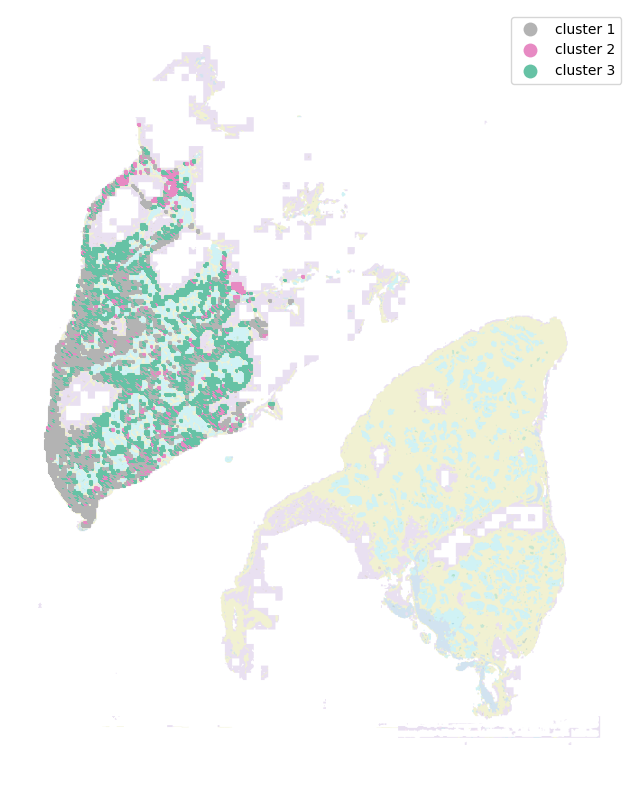

In [11]:
ax = tis.plot(figsize=(10, 10), alpha=0.2, column="class_name", aspect=1)
ax = grid_feats.plot(ax=ax, column="labels", aspect=1, legend=True, cmap="Set2_r")
ax.set_axis_off()

### Visualize H&E patches from Different Clusters

Next, we'll visualize a few H&E patches from each cluster to better understand their characteristics.

In [12]:
import matplotlib.pyplot as plt
import numpy as np


def polygon_to_xywh(polygon):
    """Convert polygon to xywh coordinates for slide reader."""
    minx, miny, maxx, maxy = polygon.bounds
    return (int(minx), int(miny), int(maxx - minx), int(maxy - miny))


def extract_cluster_images(cluster_patches_dict, reader):
    """Extract images for all clusters."""
    cluster_images = {}

    for cluster, patches in cluster_patches_dict.items():
        images = []
        patch_info = []

        for idx, _ in patches.iterrows():
            original_geom = gr.loc[idx, "geometry"]
            x, y, w, h = polygon_to_xywh(original_geom)

            img = reader.read_region((int(x), int(y), int(w), int(h)), 0)
            images.append(img)
            patch_info.append({"idx": idx, "cluster": cluster, "coords": (x, y, w, h)})

        cluster_images[cluster] = {"images": images, "info": patch_info}

    return cluster_images


# Get unique cluster labels
unique_clusters = np.unique(grid_feats["labels"])

# Sample patches from each cluster (2-3 per cluster)
patches_per_cluster = 3
cluster_patches = {}

for cluster in unique_clusters:
    cluster_data = grid_feats[grid_feats["labels"] == cluster]
    sampled = cluster_data.sample(n=patches_per_cluster, random_state=45)
    cluster_patches[cluster] = sampled

cluster_images = extract_cluster_images(cluster_patches, reader)

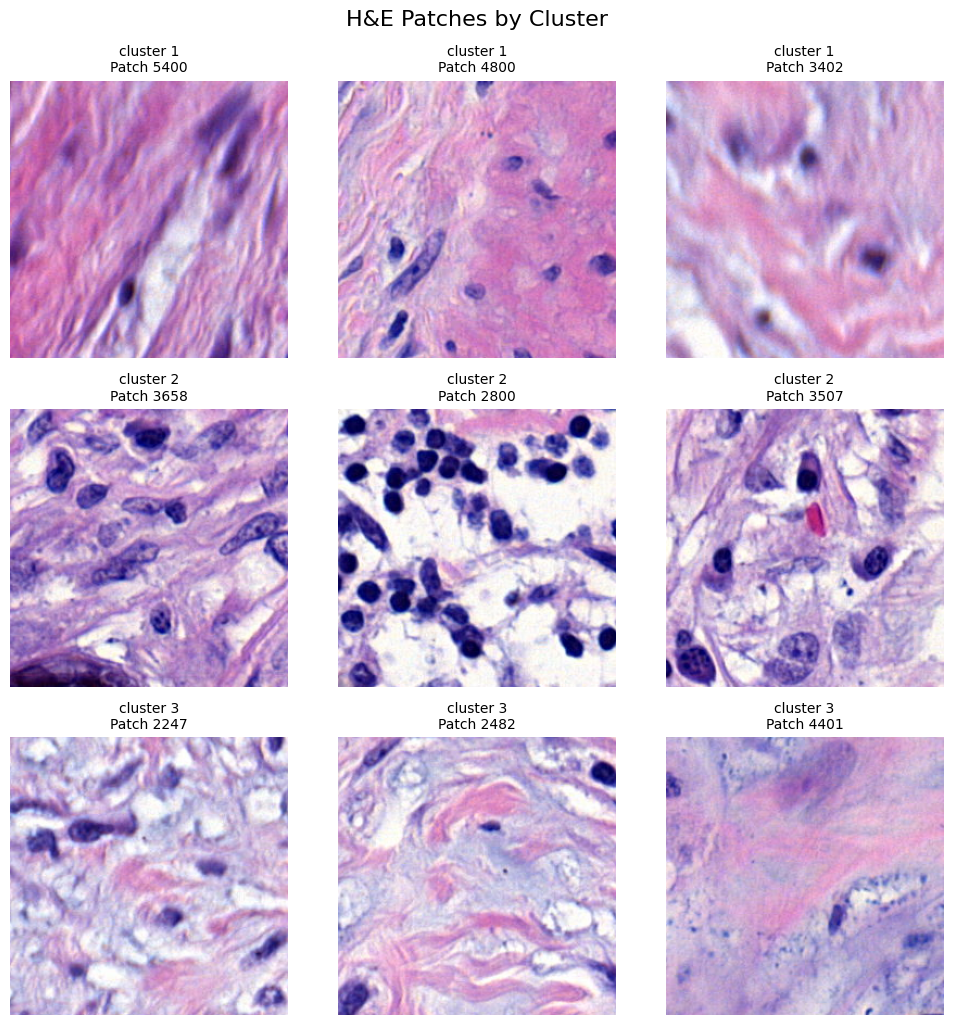

In [13]:
# Visualize patches from all clusters in a grid
n_clusters = len(cluster_images)
max_patches = max([len(data["images"]) for data in cluster_images.values()])

fig, axes = plt.subplots(n_clusters, max_patches, figsize=(10, 10))

for cluster_idx, (cluster, data) in enumerate(cluster_images.items()):
    images = data["images"]
    info = data["info"]

    for patch_idx, (img, patch_info) in enumerate(zip(images, info)):
        ax = axes[cluster_idx, patch_idx]
        ax.imshow(img)
        ax.set_title(f"{cluster}\nPatch {patch_info['idx']}", fontsize=10)
        ax.axis("off")

    for patch_idx in range(len(images), max_patches):
        axes[cluster_idx, patch_idx].axis("off")

plt.tight_layout()
plt.suptitle("H&E Patches by Cluster", fontsize=16, y=1.02)
plt.show()

Based on these H&E patches, we could conclude that the Cluster 1 represents mature desmoplastic stroma, Cluster 2 represents immune dense stroma, and Cluster 3 represents immature desmoplastic stroma.

### Conclusions

In this workflow we demonstrated how to leverage unsupervised clustering techniques to identify distinct stromal phenotypes in histological images. By extracting and analyzing a comprehensive set of features, we were able to differentiate between mature desmoplastic stroma, immune dense stroma, and immature desmoplastic stroma. This approach can help to enhance our understanding of the tumor microenvironment: For example, these identified stromal clusters can be used to stratify features of individual stromal nuclei or to quantify the overall stromal composition of an entire slide, which can then be directly correlated with clinical outcomes. But we'll leave that for another time.